In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

%matplotlib inline
xref = np.array([1e-9, 1e-9, 1e-9])

In [3]:
def get_jacobian(net, x, noutputs):
    x = x.squeeze()
    n = x.size()[0]
    x = x.repeat(noutputs, 1)
    x.requires_grad_(True)
    y = net(x)
    y.backward(torch.eye(noutputs))
    return x.grad.data


class SquaredNet(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()
        
        self.input_features = input_features
        self.output_features = output_features

        self.fc1 = nn.Linear(self.input_features, 8)
        f1 = 1 / np.sqrt(self.fc1.weight.data.size()[0])
        torch.nn.init.normal_(self.fc1.weight.data, -f1, f1)
        torch.nn.init.uniform_(self.fc1.bias, -f1, f1)        
        

        self.fc2 = nn.Linear(8, 8)
        f2 = 1 / np.sqrt(self.fc2.weight.data.size()[0])
        torch.nn.init.normal_(self.fc2.weight.data, -f2, f2)
        torch.nn.init.uniform_(self.fc2.bias, -f2, f2)        
        
                
        self.fc3 = nn.Linear(8, 3)
        f3 = 1 / np.sqrt(self.fc3.weight.data.size()[0])
        torch.nn.init.normal_(self.fc3.weight.data, -f3, f3)
        torch.nn.init.uniform_(self.fc3.bias, -f3, f3)   
        
        self.fc4 = nn.Linear(3, self.output_features)        
        self.device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        
        x = torch.relu(self.fc1(x)) 
        x = torch.tanh(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x4 = self.fc4(x)**2
        return x4
    

In [4]:
def generateNumpyData(size = 1000, test=False):

    
    xtrain = []
    ytrain = []
    for _ in range(size):
        if not test:
            xyz = np.array([np.random.uniform(-2.1, 2.1), 
                       np.random.uniform(-2.1, 2.1),
                       np.random.uniform(0, 1)])
    
        if test:
            xyz = np.array([np.random.uniform(-0.2, 0.2), 
                       np.random.uniform(-.2, .2),
                       np.random.uniform(0, 1)])
    
            
        xtrain.append(xyz)
        ytrain.append(np.array([np.sum(np.abs(xyz - xref )**2)]))
        
    
    return np.asarray(xtrain), np.asarray(ytrain)

In [5]:
def trainFfn(net, start, cost, epochs = 110):
    from tqdm import tqdm
    net = net.float()
    net.train()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    n_epochs = epochs
    for epoch in tqdm(range(n_epochs)):
        for x, y in zip(start, cost):
                       
            optimizer.zero_grad()
            y_ = net(x)          
            loss = torch.sum((torch.abs(y_ - y))**2)

            loss.backward()
            optimizer.step()  
    del start, cost        
    return net

In [6]:
xtrain, ytrain = generateNumpyData()
xtrain = torch.as_tensor(xtrain, dtype = torch.float32)
ytrain = torch.as_tensor(ytrain, dtype = torch.float32)
net = SquaredNet(xtrain.shape[1], ytrain.shape[1])
ffn = trainFfn(net, xtrain, ytrain)


100%|██████████| 110/110 [01:30<00:00,  1.21it/s]


In [9]:
# Calculate MSE for test
def evalMSE(net, size  = 1000):
    x, lx = generateNumpyData(size)
    net.eval()
    totalLoss = 0.
    with torch.no_grad():
        for test, target in zip(x, lx):
            test = torch.as_tensor(test, dtype = torch.float32)
            prediction = net(test).cpu().detach().numpy()
            totalLoss += np.abs(prediction - target) ** 2
    return totalLoss / size
        
        

In [10]:
print(f"MSE for Squared Network is : {evalMSE(ffn, 1000)}")

MSE for Squared Network is : [0.06957466]


In [11]:
# Calculate MSDE

def evalMSDE(net, size):
    def numpyMSE(x):
        """
        this should return the ytrain
        """
        return np.sum(np.abs(x - xref )**2)
    
    jacobianLossFunction = nd.Jacobian(numpyMSE)
    net.eval()
    MSDE = 0.
    for _ in range(size):
        xyz = np.array([np.random.uniform(-2.1, 2.1), 
                       np.random.uniform(-2.1, 2.1),
                       np.random.uniform(0, 1)])
        
        # calculate the derivative of loss with respect to numpy, del L
        delLf = jacobianLossFunction(xyz)
        
        # convert input to tensor
        test = torch.as_tensor(xyz, dtype = torch.float32)
        # Get derivative of net prediction
        delNw = get_jacobian(net, test, 1).detach().numpy()
        
        # Calculate the sum of squared errors for the two arrays
        loss = np.sum(np.abs(delLf - delNw )**2)
        MSDE += loss
        
    return MSDE / size


In [12]:
print(f"MSDE for Squared Network is : {evalMSDE(ffn, 1000)}")                  


MSDE for Squared Network is : 0.9106432223950506


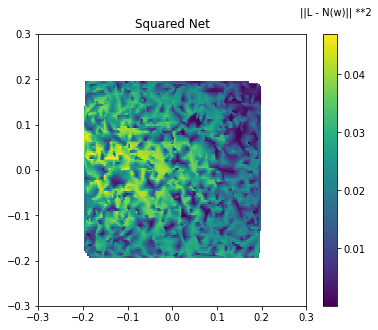

In [17]:
def mse_plot_data(net, size=2000):
    xyz, lx = generateNumpyData(size, True)
    net.eval()
    mse = []
    for test, target in zip(xyz, lx):
        test = torch.as_tensor(test, dtype = torch.float32)
        prediction = net(test).cpu().detach().numpy()
        mse.append(np.array([np.abs(prediction - target) ** 2]))
    mse = np.array(mse).squeeze().reshape(size, 1)
    
    x = xyz[:,0]
    y = xyz[:,1]
    z = mse[:,0]
    extent = (min(x), max(x), min(y), max(y))
    xs,ys = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
    z_resampled = griddata((x, y), z, (xs, ys)) #2D z
    plt.figure(figsize=(6,5))
    plt.imshow(z_resampled, interpolation="none", extent=extent, origin="lower", aspect='auto')
    plt.xticks(np.arange(-0.3, 0.31, step=0.1))
    plt.yticks(np.arange(-0.3, 0.31, step=0.1))
    clb = plt.colorbar()
    clb.set_label("||L - N(w)|| **2", labelpad=-30, y=1.10, rotation=0)
    plt.title("Squared Net")
    plt.savefig("FSQU Net LNW.png")
    plt.show()

mse_plot_data(ffn)    

In [18]:
def msde_plot_data(net, size=2000):
    def numpyMSE(x):
        """
        this should return the ytrain
        """
        return np.sum(np.abs(x - xref )**2)
    positions = []
    jacobianLossFunction = nd.Jacobian(numpyMSE)
    net.eval()
    msde = []
    for _ in range(size):
        xyz = np.array([np.random.uniform(-0.2, 0.2), 
                       np.random.uniform(-0.2, 0.2),
                       np.random.uniform(0, 1)])
        positions.append(xyz)
        # calculate the derivative of loss with respect to numpy, del L
        delLf = jacobianLossFunction(xyz)
        
        # convert input to tensor
        test = torch.as_tensor(xyz, dtype = torch.float32)
        # Get derivative of net prediction
        delNw = get_jacobian(net, test, 1).detach().numpy()
        
        # Calculate the sum of squared errors for the two arrays
        loss = np.sum(np.abs(delLf - delNw )**2)
        msde.append(np.array([loss]))
        
    msde = np.array(msde).squeeze().reshape(size, 1)
    positions = np.array(positions)
    
    x = positions[:,0]
    y = positions[:,1]
    z = msde[:,0]
    extent = (min(x), max(x), min(y), max(y))
    xs,ys = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
    z_resampled = griddata((x, y), z, (xs, ys)) 
    plt.figure(figsize=(6,5))

    plt.imshow(z_resampled,
               interpolation="none",
               extent=extent,
               origin="lower",
               aspect='auto',
               )

    plt.xticks(np.arange(-0.3, 0.31, step=0.1))
    plt.yticks(np.arange(-0.3, 0.31, step=0.1))
    clb = plt.colorbar()

    clb.set_label("||del L - del N(w)||**2", labelpad=-30, y=1.10, rotation=0)

    plt.title("Squared Net")
    plt.savefig("SQ Net delLNW.png")
    plt.show()
    


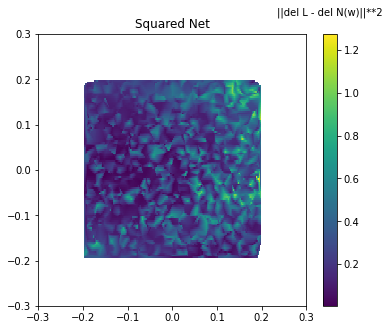

In [14]:
msde_plot_data(ffn)

In [15]:
def scatter2(net):
    xyz, lx = generateNumpyData(1000, True)
    net.eval()
    predictions = []
    for test, target in zip(xyz, lx):
        test = torch.as_tensor(test, dtype = torch.float32)
        prediction = net(test).cpu().detach().numpy()
        predictions.append(np.array([prediction]))
        
    predictions = np.array(predictions).squeeze().reshape(1000, 1)
    
    x = xyz[:,0]
    y = xyz[:,1]
    z = predictions[:,0]
    extent = (min(x), max(x), min(y), max(y))
    xs,ys = np.mgrid[extent[0]:extent[1]:100j, extent[2]:extent[3]:200j] #2D x,y
    z_resampled = griddata((x, y), z, (xs, ys)) #2D z
    plt.figure(figsize=(6,5))

    plt.imshow(z_resampled, interpolation="none", extent=extent, origin="lower", aspect='auto')
    #plt.xlim(-0.2, 0.2)
    #plt.ylim(-0.2,0.2)
    plt.xticks(np.arange(-0.3, 0.31, step=0.1))
    plt.yticks(np.arange(-0.3, 0.31, step=0.1))
    clb = plt.colorbar()
    clb.set_label("N(x))", labelpad=-30, y=1.10, rotation=0)
    plt.title("Squared Topology")
    plt.savefig("nw2.png")
    plt.show()    

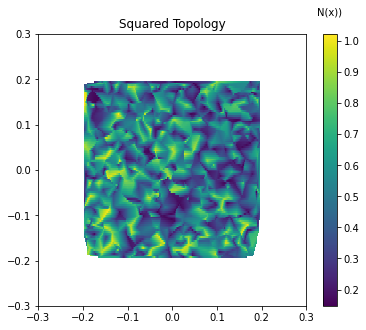

In [16]:
scatter2(ffn)